In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import torch
import transformers
from tqdm.auto import trange, tqdm

from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models.integrator import ContrastiveEmbeddingModel, get_sequence
from src.utils.timit import load_or_prepare_timit_corpus

In [4]:
model_checkpoint = "out/ce_model_phoneme_within_word_prefix_6_32/checkpoint-600"
equiv_dataset_path = "data/timit_equiv_phoneme_within_word_prefix_1.pkl"

In [5]:
model = ContrastiveEmbeddingModel.from_pretrained(model_checkpoint)
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [6]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [7]:
assert model.is_compatible_with(equiv_dataset)

In [8]:
# Compute representations in batch
model_representations = []

batch_size = 16
# non_null_frames = (equiv_dataset.Q != -1).nonzero(as_tuple=True)[0]
F = equiv_dataset.hidden_state_dataset.get_layer(model.config.base_model_layer)
# for batch_start in trange(0, len(non_null_frames), batch_size):
for batch_start in trange(0, equiv_dataset.hidden_state_dataset.num_frames, batch_size):
    # batch_idxs = non_null_frames[batch_start:batch_start + batch_size]
    batch_idxs = torch.arange(batch_start, min(batch_start + batch_size, equiv_dataset.hidden_state_dataset.num_frames))
    batch = torch.stack([get_sequence(F, equiv_dataset.S[idx], idx, model.config.max_length)
                         for idx in batch_idxs])
    lengths = torch.minimum(equiv_dataset.lengths[batch_idxs], torch.tensor(model.config.max_length))
    lengths[lengths <= 0] = 1

    with torch.no_grad():
        model_representations.append(model.compute_embeddings(batch, lengths).cpu().numpy())

  0%|          | 0/4740 [00:00<?, ?it/s]

In [9]:
model_representations = np.concatenate(model_representations, axis=0)
model_representations.shape

(75836, 32)

## State space analysis

In [10]:
from collections import Counter
class_freqs = Counter([equiv_dataset.class_labels[label_idx] for label_idx in equiv_dataset.Q.numpy() if label_idx >= 0])
class_freqs.most_common()

[(('T',), 439),
 (('IH',), 334),
 (('DH',), 271),
 (('W',), 267),
 (('S',), 234),
 (('K',), 217),
 (('D',), 210),
 (('HH',), 209),
 (('AH',), 180),
 (('M',), 174),
 (('B',), 169),
 (('F',), 143),
 (('Y',), 139),
 (('L',), 130),
 (('T', 'IH'), 128),
 (('IH', 'N'), 127),
 (('R',), 127),
 (('P',), 127),
 (('G',), 114),
 (('SH',), 105),
 (('N',), 99),
 (('DH', 'IH'), 91),
 (('AO',), 87),
 (('AE',), 87),
 (('DH', 'AH'), 69),
 (('W', 'AO'), 66),
 (('L', 'AY'), 66),
 (('HH', 'AE'), 63),
 (('G', 'R'), 62),
 (('EH',), 61),
 (('Y', 'IH'), 59),
 (('D', 'AA'), 58),
 (('AO', 'L'), 56),
 (('DH', 'AE'), 56),
 (('DH', 'AE', 'T'), 55),
 (('L', 'AY', 'K'), 55),
 (('S', 'UW'), 53),
 (('T', 'AH'), 53),
 (('S', 'UW', 'T'), 51),
 (('R', 'AE'), 50),
 (('G', 'R', 'IY'), 50),
 (('D', 'OW'), 50),
 (('AE', 'S'), 49),
 (('R', 'AE', 'G'), 49),
 (('SH', 'IY'), 49),
 (('AH', 'N'), 48),
 (('W', 'AA'), 48),
 (('K', 'EH'), 47),
 (('M', 'IY'), 47),
 (('G', 'R', 'IY', 'S'), 47),
 (('Y', 'IH', 'ER'), 46),
 (('HH', 'AE', '

In [11]:
Counter({k: v for k, v in class_freqs.items() if k[0] == "SH" and len(k) > 2})

Counter({('SH', 'EH', 'L'): 5,
         ('SH', 'AA', 'K'): 3,
         ('SH', 'AO', 'T'): 3,
         ('SH', 'IY', 'L'): 2,
         ('SH', 'ER', 'B'): 2,
         ('SH', 'ER', 'B', 'ER'): 2,
         ('SH', 'ER', 'B', 'ER', 'T'): 2,
         ('SH', 'EH', 'L', 'F'): 2,
         ('SH', 'EH', 'L', 'F', 'IH'): 2,
         ('SH', 'EH', 'L', 'F', 'IH', 'SH'): 2,
         ('SH', 'IH', 'M'): 2,
         ('SH', 'IH', 'D'): 2,
         ('SH', 'AO', 'T', 'AH', 'N'): 2,
         ('SH', 'UH', 'D'): 2,
         ('SH', 'AO', 'R'): 2,
         ('SH', 'AO', 'R', 'T'): 2,
         ('SH', 'AA', 'R'): 2,
         ('SH', 'AA', 'R', 'P'): 2,
         ('SH', 'IY', 'L', 'IH'): 1,
         ('SH', 'AO', 'N'): 1,
         ('SH', '[SIL]', 'R'): 1,
         ('SH', '[SIL]', 'R', 'AE'): 1,
         ('SH', '[SIL]', 'R', 'AE', 'P'): 1,
         ('SH', '[SIL]', 'R', 'AE', 'P', 'N'): 1,
         ('SH', '[SIL]', 'R', 'AE', 'P', 'N', 'OW'): 1,
         ('SH', 'IH', 'M', 'IH'): 1,
         ('SH', 'IH', 'M', 'IH', 'D'): 1,

In [12]:
pca = PCA(n_components=2)
model_representations_pca = pca.fit_transform(model_representations)

In [13]:
# TODO look for an interesting cohort trajectory in the stimulus, maybe by looking at counts?
final_words = [tuple(x.split(" ")) for x in
               ["SH AA K", "SH AO R", "SH AO T", "SH EH L F", "SH ER B ER T"]]
label_trajectories = [
    [word[:i + 1] for i in range(len(word))]
    for word in final_words
]
# label_trajectories = [
#     # # trajectory 1
#     # [
#     #     # frame 1
#     #     ("SH",),
#     #     # frame 2
#     #     ("SH", "IH"),
#     # ],
#     # [("SH",), ("SH", "AA"),],
#     [("SH",), ("SH", "AO"), ("SH", "AO", "R")],
#     [("SH",), ("SH", "AO"), ("SH", "AO", "T")],
#     [("SH",), ("SH", "EH"), ("SH", "EH", "L")],
#     [("SH",), ("SH", "ER"), ("SH", "ER", "B")],
#     [("SH",), ("SH", "IY"), ("SH", "IY", "L")],
# ]

label_idx_trajectories = [
    [equiv_dataset.class_labels.index(label) for label in trajectory]
    for trajectory in label_trajectories
]

# Extract matching model representations for each frame of each trajectory.
trajectory_frame_bounds = []
for i, trajectory in enumerate(label_idx_trajectories):
    # Select only samples consistent with the end of the trajectory.
    # We do this by finding the start frame of the last animation step, and
    # only allowing frames within the span of the start frame and the frame
    # of the last animation step.
    last_anim_label_idx = trajectory[-1]
    last_anim_frames = torch.where(equiv_dataset.Q == last_anim_label_idx)[0].numpy()
    start_frames = equiv_dataset.S[last_anim_frames].numpy()
    trajectory_frame_bounds.append((start_frames, last_anim_frames))

max_num_frames = max((end_frames - start_frames + 1).max()
                     for start_frames, end_frames in trajectory_frame_bounds)

trajectory_representations = []
for i, (start_frames, end_frames) in enumerate(trajectory_frame_bounds):
    num_instances = len(start_frames)

    # Trajectory indexed by model frame
    trajectory_frames = np.zeros((num_instances, max_num_frames, 2), dtype=float)
    for j, (start_frame, end_frame) in enumerate(zip(start_frames, end_frames)):
        num_frames_j = end_frame - start_frame + 1
        trajectory_frames[j, :num_frames_j, :] = model_representations_pca[start_frame:end_frame + 1]

        # Fill on right
        if num_frames_j < max_num_frames:
            trajectory_frames[j, num_frames_j:, :] = trajectory_frames[j, num_frames_j - 1, :]

    trajectory_representations.append(trajectory_frames)

In [14]:
trajectory_representations[0].shape

(3, 31, 2)

In [15]:
list(zip(["-".join(x[-1] for x in traj) for traj in label_trajectories],
         [traj.shape[0] for traj in trajectory_representations]))

[('SH-AA-K', 3),
 ('SH-AO-R', 2),
 ('SH-AO-T', 3),
 ('SH-EH-L-F', 2),
 ('SH-ER-B-ER-T', 2)]

In [16]:
%matplotlib ipympl

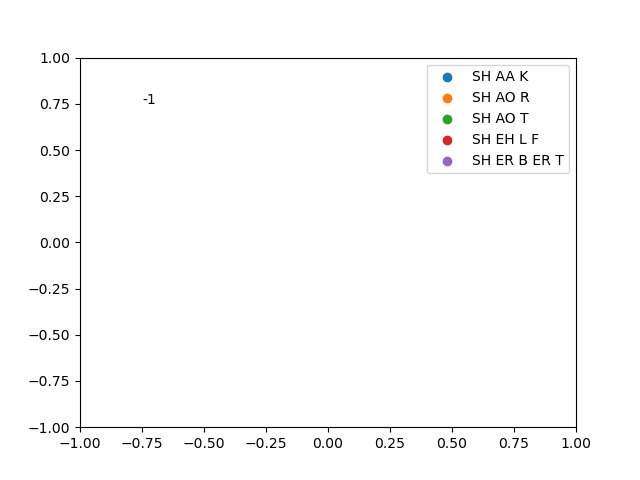

In [17]:
# Animate
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
annot_frame = ax.text(-0.75, 0.75, "-1")
scats = [ax.scatter([], []) for _ in trajectory_representations]
ax.legend(scats, [" ".join(phonemes) for phonemes in final_words])

def init():
    for scat in scats:
        scat.set_offsets(np.zeros((0, 2)))
    return tuple(scats)

def update(frame):
    for scat, trajectory in zip(scats, trajectory_representations):
        scat.set_offsets(trajectory[:, frame])
    annot_frame.set_text(str(frame))
    return tuple(scats) + (annot_frame,)

# Animate by model frame
num_frames = trajectory_representations[0].shape[1]
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=500,
                              init_func=init)
plt.show()

## Plot matched phonemes in different contexts

In [18]:
target_phoneme = "T"
max_context_size = 2

In [19]:
matching_label_idxs = [idx for idx, label in enumerate(equiv_dataset.class_labels) if label[-1] == target_phoneme]

phoneme_reprs = [model_representations[labels == idx] for idx in matching_label_idxs]
phoneme_labels = [np.repeat("".join(equiv_dataset.class_labels[idx][-max_context_size:]), len(repr))
                  for idx, repr in zip(matching_label_idxs, phoneme_reprs)]
phoneme_reprs = np.concatenate(phoneme_reprs)
phoneme_labels = np.concatenate(phoneme_labels)

phoneme_label_idxs = {label: idx for idx, label in enumerate(np.unique(phoneme_labels))}
print(f"{len(phoneme_label_idxs)} unique labels")
phoneme_label_idxs = np.array([phoneme_label_idxs[label] for label in phoneme_labels])

NameError: name 'labels' is not defined

In [ ]:
# phoneme_reprs_pca = PCA(n_components=2).fit_transform(phoneme_reprs)
phoneme_reprs_pca = pca.transform(phoneme_reprs)

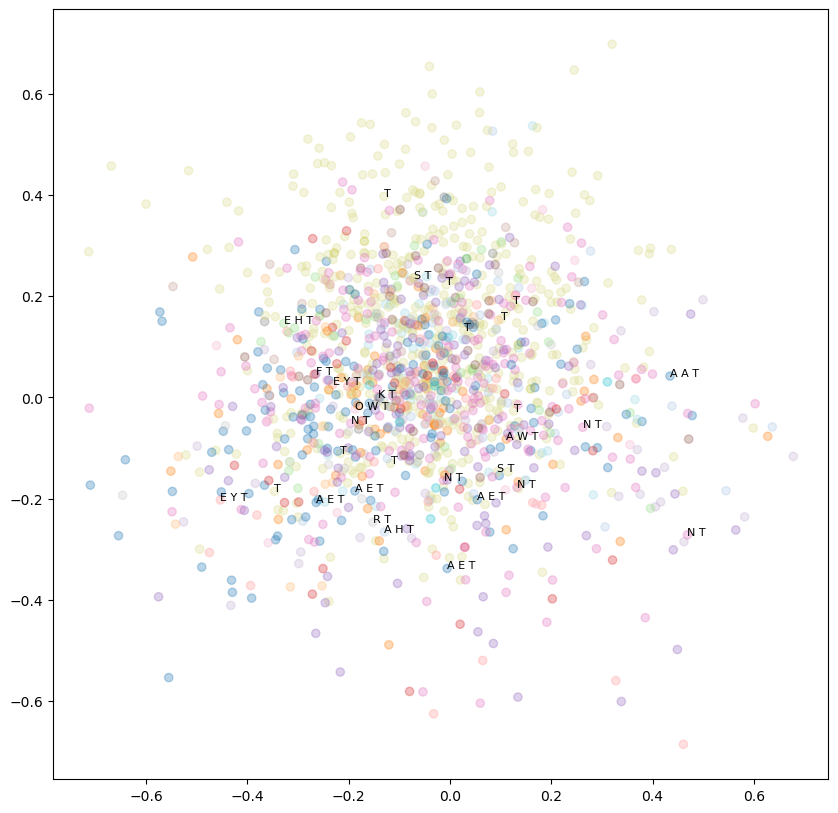

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(phoneme_reprs_pca[:, 0], phoneme_reprs_pca[:, 1], alpha=0.3, c=phoneme_label_idxs, cmap="tab20")

annotate_idxs = np.random.choice(len(phoneme_reprs), 30, replace=False)
for idx in annotate_idxs:
    ax.annotate(" ".join(phoneme_labels[idx]), phoneme_reprs_pca[idx], fontsize=8)